# Analyse BlueSeis BSPF Event Analysis - Polarization

With pressure sensor parascientific and new sensor 

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

sys.path.append("/home/andbro/andbro_python")
from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
sys.path.append("/home/andbro/Documents/ROMY/twistpy/TwistPy/")

In [3]:
from twistpy.utils import stransform
from twistpy.convenience import ricker
from twistpy.polarization import (
    TimeDomainAnalysis6C,
    PolarizationModel6C,
    SupportVectorMachine,
    EstimatorConfiguration,
)


## Configurations

In [4]:
workdir = "/home/andbro/Documents/ROMY/BSPF"

In [5]:
config = {}

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*" 
# config['seed_seismometer'] = "PY.BSPF..HH*" 

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643


## Borrego Springs, Ca M3.2 -> good
# config['tbeg'] = obs.UTCDateTime("2023-01-09 19:42:56")-3
# config['tend'] = config['tbeg']+35
# config['fmin'], config['fmax'] = 0.1, 15.0
# config['magnitude'] = 3.2
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Las Brisas M6.2 -> alright
config['eventtime'] = obs.UTCDateTime("2022-11-22 16:39")
config['tbeg'] = obs.UTCDateTime("2022-11-22 16:32")+30
config['tend'] = config['tbeg']+1000
config['fmin'], config['fmax'] = 0.5, 2.0
config['magnitude'] = 6.3
config['title'] = f"Las Brisas, Mexico | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## Borrego Springs, California M4.2 -> good
# config['tbeg'] = obs.UTCDateTime("2022-12-31 12:12:25")-5
# config['tend'] = config['tbeg']+80
# config['fmin'], config['fmax'] = 0.01, 10.0
# config['magnitude'] = 4.2
# config['title'] = f"Borrego Springs, Ca | {config['tbeg'].date} {str(config['tbeg'].time)[:5]} UTC | M{config['magnitude']}"

## store config
__store_as_pickle(config, f"./configs/{str(config['tbeg'].date).replace('-','')}_M{config['magnitude']}.pkl")

## Load Data

In [6]:
def __request_data(seed, tbeg, tend):

    from obspy.clients.fdsn import Client

    client = Client("IRIS")

    net, sta, loc, cha = seed.split(".")

    try:
        inventory = client.get_stations(network=net, 
                                         station=sta,
                                         starttime=tbeg,
                                         endtime=tend,
                                         level="response",
                                         )
    except:
        print("Failed to load inventory!")
        inventory = None
        
    try:
        waveform = client.get_waveforms(network=net,
                                       station=sta,
                                       location=loc,
                                       channel=cha, 
                                       starttime=tbeg-60,
                                       endtime=tend+60,
                                       )

    except:
        print("Failed to load waveforms!")
        waveform = None
    
    return waveform, inventory

In [7]:
py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

In [8]:
ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])

## PreProcessing

In [9]:
def __process_acc_data(config, st, inv):
    
    ii_pfo_acc = st.copy()

    pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
    ii_pfo_acc.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo_acc.detrend("demean")

    ## remove response
    ii_pfo_acc.remove_response(inventory=inv, 
                           pre_filt=pre_filt, 
                           output="ACC",
#                            water_level=60, 
                           plot=False)

    ## taper 
    ii_pfo_acc.taper(0.1)

    ## bandpass
    ii_pfo_acc.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    ii_pfo_acc.detrend("demean")
    
    ## adjust channel names
    for tr in ii_pfo_acc:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")

    ## show stream
    print(ii_pfo_acc)
            
    ii_pfo_acc.plot(equal_scale=False);
    
    return ii_pfo_acc

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHE | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples
II.PFO.10.BHZ | 2022-11-22T16:32:29.994538Z - 2022-11-22T16:49:09.994538Z | 40.0 Hz, 40001 samples


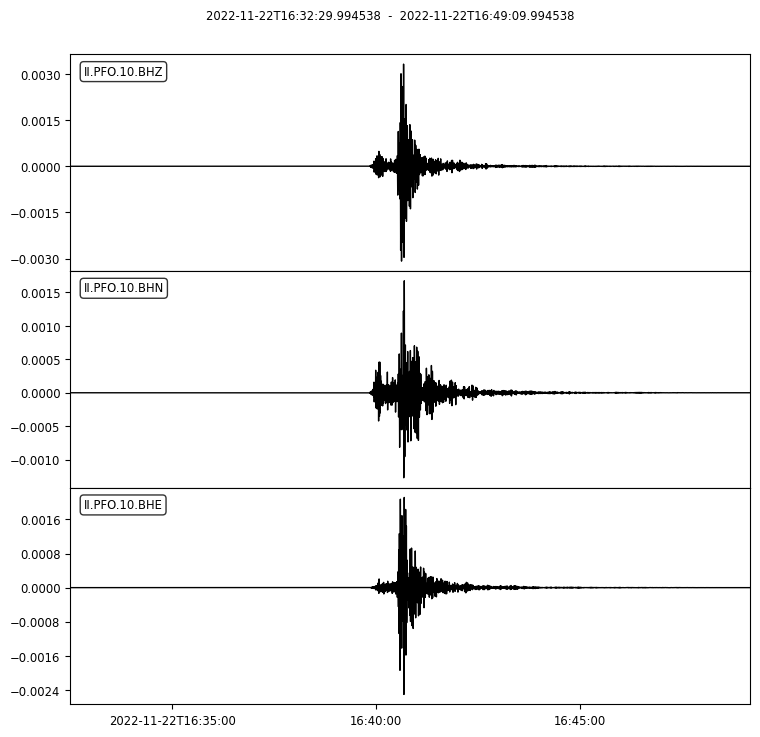

In [10]:
ii_pfo_acc = __process_acc_data(config, ii_pfo0, ii_pfo_inv)

In [11]:
def __process_rot_data(config, st, inv):
    
    py_bspf = st.copy()

    ## merge traces that might be split due to data gaps or overlaps
    py_bspf.merge(fill_value="interpolate")

    ## renove sensitivity
    py_bspf.remove_sensitivity(inv)
    
    ## resample to 40 Hz as acc data
    py_bspf.resample(40)
    
    ## cut to event
    py_bspf.trim(config['tbeg'], config['tend'])
    
    ## remove mean
    py_bspf.detrend("demean")

    ## apply taper
    py_bspf.taper(0.1)

    ## bandpass filter
    py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True)

    ## remove mean
    py_bspf.detrend("demean")    
    

    
    ## adjust channel names
    for tr in py_bspf:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","E")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","N")        
        if tr.stats.channel[-1] == "3":
            tr.stats.channel = str(tr.stats.channel).replace("3","Z")

    ## show all traces in data stream
    print(py_bspf)

    py_bspf.plot(equal_scale=False);

    return py_bspf

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJN | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples
PY.BSPF..HJZ | 2022-11-22T16:32:30.001000Z - 2022-11-22T16:49:10.001000Z | 40.0 Hz, 40001 samples


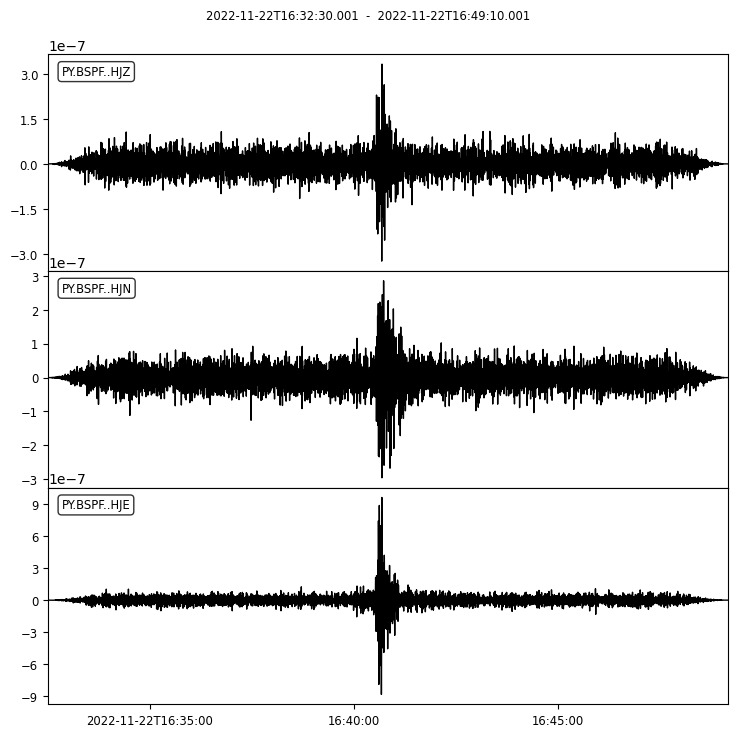

In [12]:
py_bspf = __process_rot_data(config, py_bspf0, py_bspf_inv)

## S-Transform

In [13]:
py_z = py_bspf.copy().select(channel="*E")[0].trim(config['tbeg']+7*60, config['tend']-7*60)
py_z.resample(config['fmax']*2)

py_z_trans = stransform(py_z.data)
py_z_time = py_z.times()

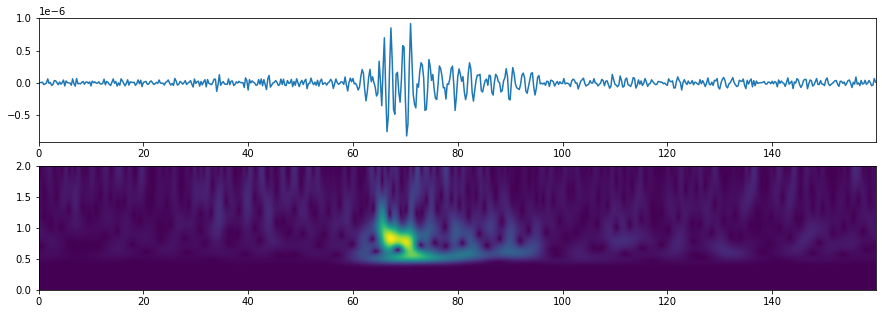

In [14]:
fig, ax = plt.subplots(2, 1,figsize=(15,5))

ax[0].plot(py_z_time, py_z.data)
ax[0].set_xlim(py_z_time[0], py_z_time[-1])

ax[1].imshow(
    np.abs(py_z_trans[0]),
    origin="lower",
    extent=[py_z_time[0], py_z_time[-1], 0, config['fmax'],],
    aspect="auto",
)

## Polarization Analysis

In [15]:
dt = py_bspf[0].stats.delta

scaling_velocity = 4500.0

### Train Model

In [16]:
svm = SupportVectorMachine(name="love_wave")

########################################################################################################################
# Now we can train the model. For details, please check the example on how to train a
# 'twistpy.machinelearning.SupportVectorMachine' object. In short, we want to train the model for wave parameters
# that are typical for the near surface, and we want to be able to identify P, SV, SH and Rayleigh waves. This means
# that we do not make a distinction between Love and SH waves here, and Love waves will simply be contained in the SH
# wave class as the special case of horizontally propagating SH waves. Additionally, we make use of a Noise class, for
# analysis windows with a random polarization. We allow waves to arrive from all directions (azimuth range [0 360]
# degrees and inclination range [0 90] degrees).

svm.train(
    wave_types=["R", "P", "SV", "L", "Noise"],
    N=5000,
    scaling_velocity=scaling_velocity,
    vp=(4000, 6000),
    vp_to_vs=(1.7, 2.4),
    vl=(100, 3000),
    vr=(100, 3000),
    phi=(0, 360),
    theta=(0, 90),
    xi=(-90, 90),
    free_surface=True,
    C=1,
    kernel="rbf",
)

A trained model already exists with this name and is saved at '/home/andbro/Documents/ROMY/twistpy/TwistPy/twistpy/SVC_models/love_wave.pkl'
Nothing will be done! Please delete the file above if you want to re-train this model.


## Prepare

In [17]:
rot = py_bspf.copy().trim(config['tbeg']+7*60, config['tend']-7*60).taper(0.2)
acc = ii_pfo_acc.copy().trim(config['tbeg']+7*60, config['tend']-7*60).taper(0.2)

In [18]:
acc.select(channel="*Z")[0].data *= -1
rot.select(channel="*Z")[0].data *= -1

In [19]:
for tr in acc:
    tr.data /= scaling_velocity

/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


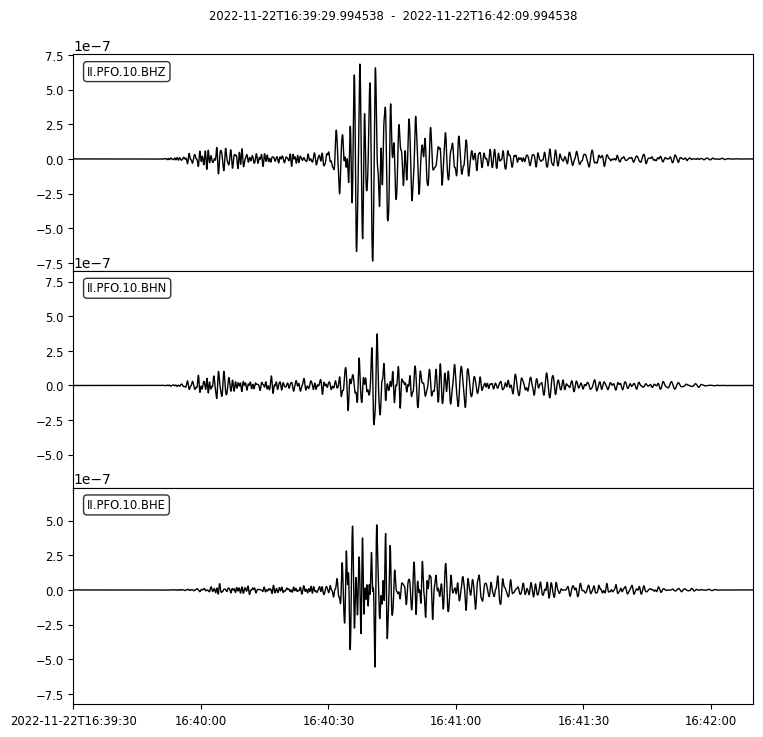

/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/obspy/imaging/util.py:275: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/obspy/imaging/waveform.py:820: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


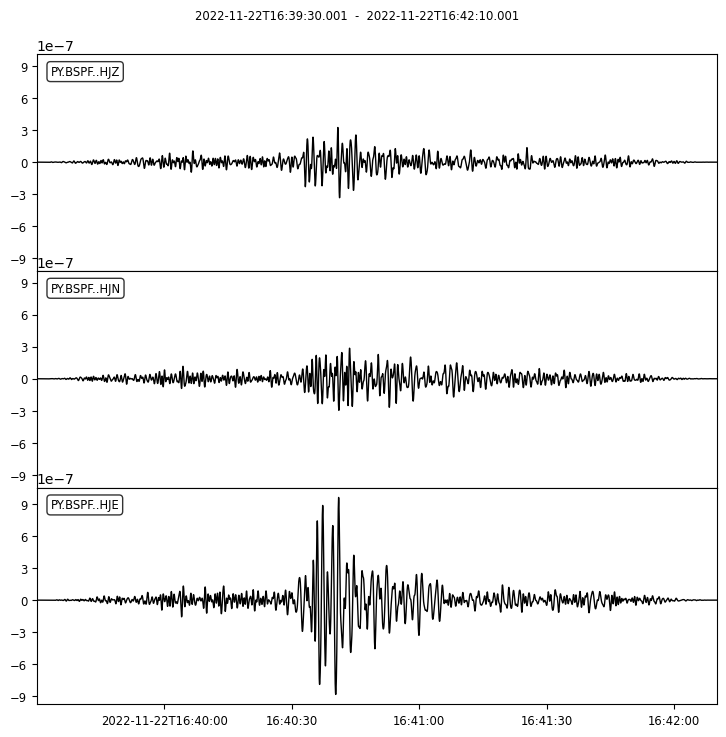

/home/andbro/anaconda3/envs/twistpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:131: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


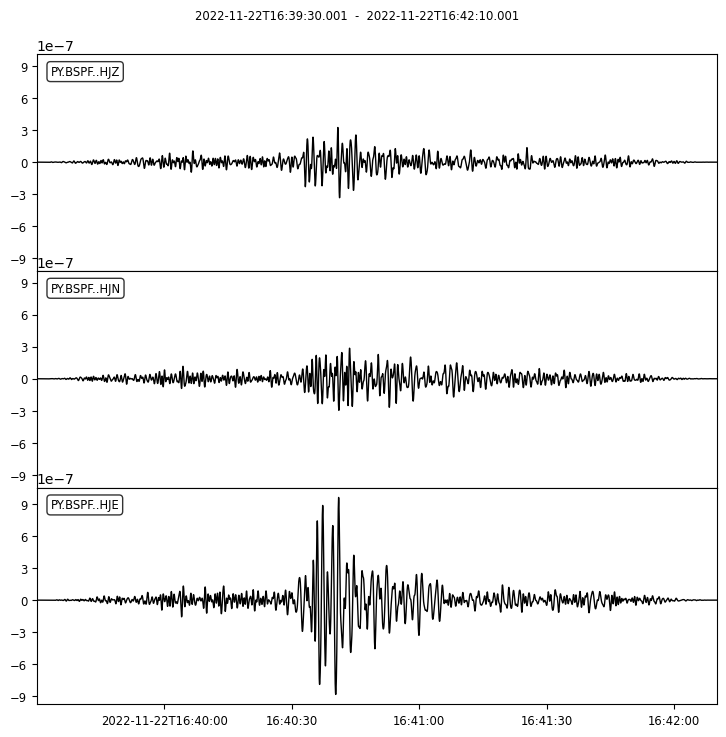

In [20]:
acc.plot()
rot.plot()

## Time Domain

In [21]:
########################################################################################################################
# Now that we have trained the model, we can set up our analysis. We will perform 6C polarization analysis in the time
# domain and use a sliding time window that is 0.05 s long (50 samples) with an overlap between subsequent windows of
# 50%.

dt = py_bspf[0].stats.delta

window = {"window_length_seconds": 50.0 * dt, "overlap": 1}

analysis = TimeDomainAnalysis6C(
                                traN=acc.select(channel="*N")[0],
                                traE=acc.select(channel="*E")[0],
                                traZ=acc.select(channel="*Z")[0],
                                rotN=rot.select(channel="*N")[0],
                                rotE=rot.select(channel="*E")[0],
                                rotZ=rot.select(channel="*Z")[0],
                                window=window,
                                scaling_velocity=scaling_velocity,
)

Computing covariance matrices...
Covariance matrices computed!


Performing eigen-decomposition of covariance matrices...
Eigenvectors and eigenvalues have been computed!
Wave type classification in progress...
Wave types have been classified!
Computing wave parameters...


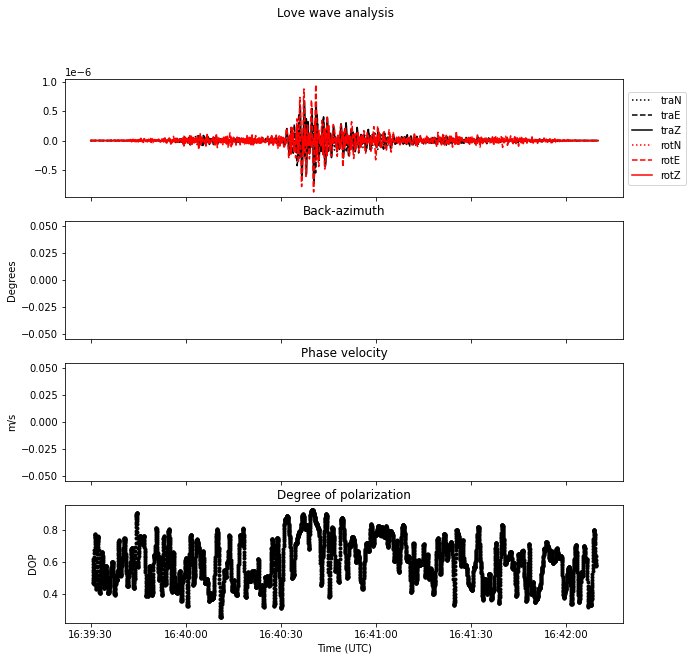

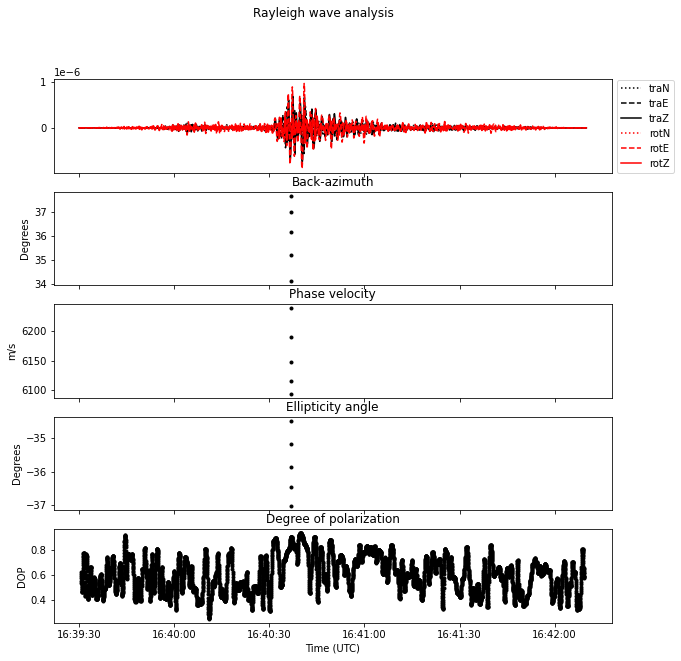

In [22]:
########################################################################################################################
# To classify the waves, we simply do (yielding a classification of the first eigenvector of the covariance matrix):

analysis.classify(svm=svm, eigenvector_to_classify=0)
classification = analysis.classification["0"]
t_windows = (
    analysis.t_windows
)  # Positions of the sliding time windows where the classification was performed

#  Wave parameter estimation

est = EstimatorConfiguration(
    wave_types=["L", "R"],
    method="ML",
    scaling_velocity=scaling_velocity,
    use_ml_classification=True,
    svm=svm,
)
analysis.polarization_analysis(estimator_configuration=est)
analysis.plot(estimator_configuration=est, dop_clip=0.9)
test = 1

## Frequency Domain

In [23]:
from twistpy.polarization import TimeFrequencyAnalysis6C, EstimatorConfiguration

In [24]:
window = {"number_of_periods": 1, "frequency_extent": 0.05}

In [25]:
analysis = TimeFrequencyAnalysis6C(
    traN=acc.select(channel="*N")[0],
    traE=acc.select(channel="*E")[0],
    traZ=acc.select(channel="*Z")[0],
    rotN=rot.select(channel="*N")[0],
    rotE=rot.select(channel="*E")[0],
    rotZ=rot.select(channel="*Z")[0],
    window=window,
    dsfacf=20,
    dsfact=20,
    frange=[0.05, 2.0],
)

Computing covariance matrices...
Covariance matrices computed!


In [26]:
from obspy import read

In [27]:
data = read("/home/andbro/Documents/ROMY/twistpy/TwistPy/example_data/ROMY_gulf_of_alaska_teleseism.mseed")
scaling_velocity = 4500.0

for n, trace in enumerate(data):
    trace.detrend("spline", order=5, dspline=100)
    trace.trim(starttime=trace.stats.starttime, endtime=trace.stats.endtime - 4500)
    trace.taper(0.2)
    if n < 3:
        trace.data /= scaling_velocity

In [28]:
window = {"number_of_periods": 1, "frequency_extent": 0.01}

In [29]:
analysis = TimeFrequencyAnalysis6C(
    traN=data[0],
    traE=data[1],
    traZ=data[2],
    rotN=data[3],
    rotE=data[4],
    rotZ=data[5],
    window=window,
    dsfacf=20,
    dsfact=20,
    frange=[0.01, 0.15],
)

Computing covariance matrices...
Covariance matrices computed!


In [30]:
est = EstimatorConfiguration(
    wave_types=["R"],
    method="DOT",
    scaling_velocity=scaling_velocity,
    use_ml_classification=False,
    vr=[3000, 4000, 100],
    xi=[-90, 90, 2],
    phi=[150, 210, 1],
    eigenvector=0,
)